In [1]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
!pip install prophet
!pip install scikit-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import math
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기

In [3]:
# 학습 데이터
data_tr = pd.read_csv('./data_city/data_tr_city.csv')
data_tr

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0
...,...,...
35058,2020-12-31 19:00:00,328.0
35059,2020-12-31 20:00:00,347.0
35060,2020-12-31 21:00:00,335.0
35061,2020-12-31 22:00:00,141.0


In [4]:
# 평가 데이터
data_ts = pd.read_csv('./data_city/data_ts_city.csv')
data_ts

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2021-01-01 00:00:00,106.0
1,2021-01-01 01:00:00,184.0
2,2021-01-01 02:00:00,277.0
3,2021-01-01 03:00:00,197.0
4,2021-01-01 04:00:00,72.0
...,...,...
8419,2021-12-17 19:00:00,327.0
8420,2021-12-17 20:00:00,513.0
8421,2021-12-17 21:00:00,396.0
8422,2021-12-17 22:00:00,350.0


In [5]:
# 제출 양식
data_sample = pd.read_csv('./data_city/sample_city.csv')
data_sample

,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8421,2021-12-17 21:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8422,2021-12-17 22:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8423,2021-12-17 23:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 복잡한 컬럼명 변경

In [6]:
data_tr.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_ts.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_tr.head()

,datetime,적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0


### 결측치 확인

In [7]:
data_tr[data_tr.적산차.isnull()]

,datetime,적산차
1748,2017-03-14 21:00:00,NaN
1982,2017-03-24 15:00:00,NaN
12716,2018-06-14 21:00:00,NaN
12717,2018-06-14 22:00:00,NaN
13187,2018-07-04 12:00:00,NaN
13234,2018-07-06 11:00:00,NaN
27253,2020-02-10 14:00:00,NaN
27254,2020-02-10 15:00:00,NaN


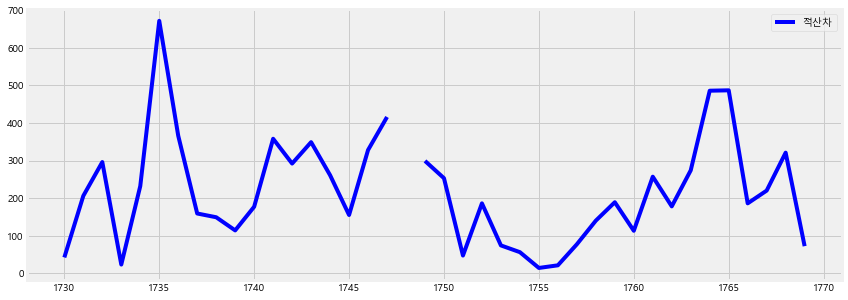

In [8]:
# 결측치 중 한 곳을 시각화
rcParams['figure.figsize'] = 13, 5
data_tr[1730:1770].plot(c='blue')
plt.show()

In [9]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')

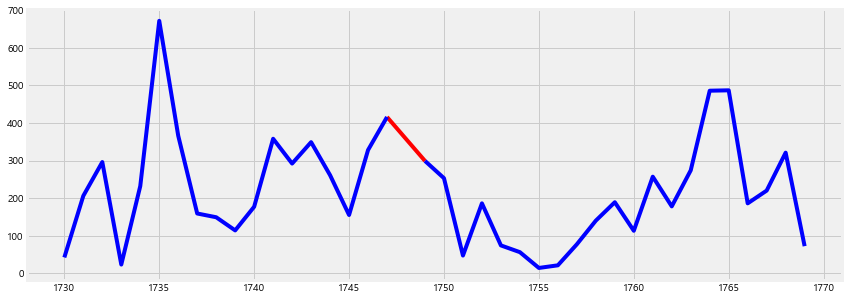

In [10]:
# 보간 후 데이터 시각화
data_tr_interpolate[1747:1750].적산차.plot(c='red')
data_tr[1730:1770].적산차.plot(c='blue')
plt.show()

data_tr = data_tr_interpolate

### 이상치 제거

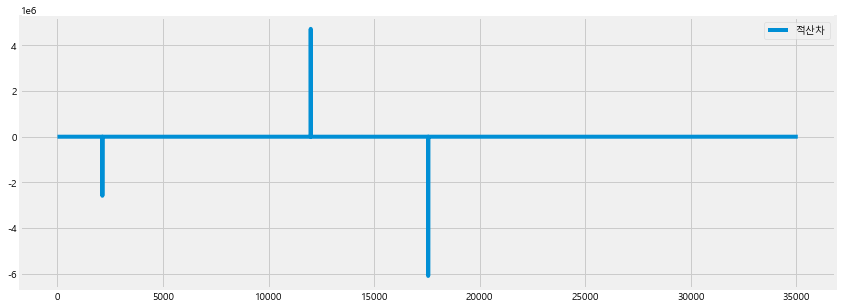

In [11]:
rcParams['figure.figsize'] = 13, 5
data_tr.plot()
plt.show()

In [12]:
data_tr[data_tr.적산차 == max(data_tr.적산차)]

,datetime,적산차
11995,2018-05-15 20:00:00,4720655.0


In [13]:
data_tr[data_tr.적산차 == min(data_tr.적산차)]

,datetime,적산차
17558,2019-01-02 15:00:00,-6093821.0


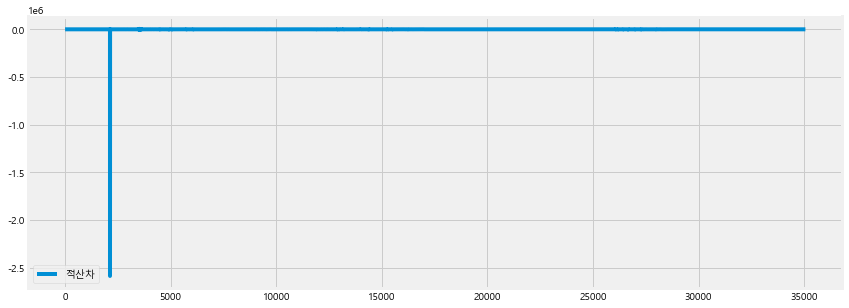

In [14]:
data_tr.drop(index=[11995, 17558], inplace=True)
data_tr.plot()
plt.show()

In [15]:
data_tr[data_tr.적산차 == min(data_tr.적산차)]

,datetime,적산차
2127,2017-03-30 16:00:00,-2584551.0


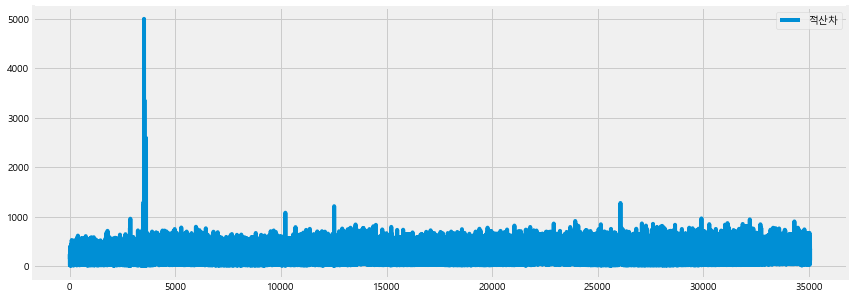

In [16]:
data_tr.drop(index=2127, inplace=True)
data_tr.plot()
plt.show()

In [17]:
data_tr.reset_index(drop=True, inplace=True)

In [18]:
data_tr['datetime'] = pd.to_datetime(data_tr['datetime'])
data_tr.set_index('datetime', inplace=True)
data_tr.head()

,적산차
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0


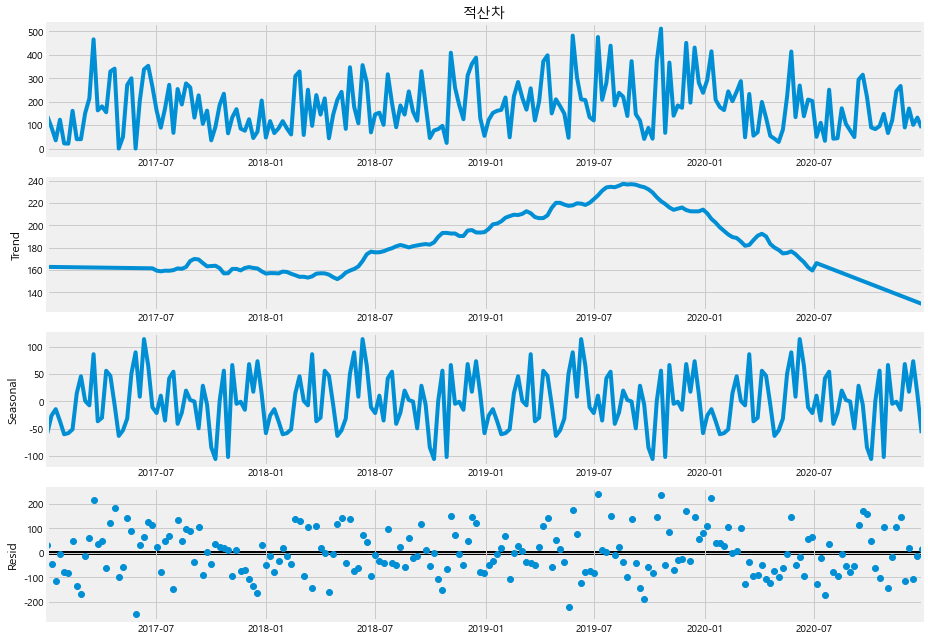

In [19]:
rcParams['figure.figsize'] = 13, 9
decomposed_df_volume = sm.tsa.seasonal_decompose(data_tr['적산차'].asfreq('W'), extrapolate_trend='freq', period=52) # py3.6 이하는 freq=52 가능
figure = decomposed_df_volume.plot()
plt.show()

* 1년의 계절성을 지녔음

### Prophet 모델

In [138]:
data_tr_prophet = data_tr.copy()
data_tr_prophet.rename(columns= {'적산차':'y'}, inplace=True)
data_tr_prophet['ds'] = data_tr_prophet.index

# yearly_Seasonality를 지닌 모델을 생성
m= Prophet(seasonality_mode='multiplicative',
          yearly_seasonality=True,
          changepoint_range=0.8,
          changepoint_prior_scale=0.2)
m.fit(data_tr_prophet)
period = 0
future = m.make_future_dataframe(periods=period, freq='H')
forecast = m.predict(future)

23:09:45 - cmdstanpy - INFO - Chain [1] start processing
23:09:55 - cmdstanpy - INFO - Chain [1] done processing


In [142]:
# 학습데이터와 예측치를 비교
forecast['original'] = list(data_tr_prophet.y) + [np.nan]*period
forecast.rename(columns={'yhat':'predict'}, inplace=True)
forecast = forecast[['ds', 'original', 'predict']]

mae = mean_absolute_error(forecast[:35060]['original'], forecast[:35060]['predict'])
print('mae :', mae)

forecast

mae : 93.64309349919488


,ds,original,predict
0,2017-01-01 01:00:00,138.0,115.216715
1,2017-01-01 02:00:00,237.0,71.577510
2,2017-01-01 03:00:00,128.0,35.546131
3,2017-01-01 04:00:00,14.0,9.489044
4,2017-01-01 05:00:00,11.0,2.747398
...,...,...,...
35055,2020-12-31 19:00:00,328.0,316.536298
35056,2020-12-31 20:00:00,347.0,375.803895
35057,2020-12-31 21:00:00,335.0,417.775658
35058,2020-12-31 22:00:00,141.0,414.980067


#### gridsearch 구현

In [172]:
changepoint_range = np.arange(0.5, 0.95, 0.05)
changepoint_prior_scale = np.arange(0.05, 0.95, 0.05)
cnt, best_mae = 0, ' '

for cr in tqdm(changepoint_range):
    cr = round(cr, 2)
    for cps in changepoint_prior_scale:
        cps = round(cps, 2)
        cnt += 1
        
        m= Prophet(seasonality_mode='multiplicative',
          yearly_seasonality=True,
          changepoint_range=cr,
          changepoint_prior_scale=cps)
        m.fit(data_tr_prophet)
        future = pd.DataFrame({'ds':data_ts['datetime']})
        forecast = m.predict(future)
        
        forecast['original'] = data_ts.적산차
        forecast.rename(columns={'yhat':'predict'}, inplace=True)
        forecast = forecast[['ds', 'original', 'predict']]

        mae = mean_absolute_error(forecast['original'], forecast['predict'])
        print('cr, cps : {}, {}, mae : {}'.format(cr, cps, mae), 'best mae :', best_mae)

        if cnt == 1:
            best_mae = mae
        
        if best_mae > mae:
            best_mae, best_cr, best_cps = mae, cr, cps

  0%|          | 0/9 [00:00<?, ?it/s]00:18:13 - cmdstanpy - INFO - Chain [1] start processing
00:18:19 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.05, mae : 95.47524486881431 best mae :  


00:18:23 - cmdstanpy - INFO - Chain [1] start processing
00:18:33 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.1, mae : 95.60863597538018 best mae : 95.47524486881431


00:18:37 - cmdstanpy - INFO - Chain [1] start processing
00:18:48 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.15, mae : 95.3658221621393 best mae : 95.47524486881431


00:18:52 - cmdstanpy - INFO - Chain [1] start processing
00:19:04 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.2, mae : 95.3252423510313 best mae : 95.3658221621393


00:19:08 - cmdstanpy - INFO - Chain [1] start processing
00:19:17 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.25, mae : 95.4060561741783 best mae : 95.3252423510313


00:19:21 - cmdstanpy - INFO - Chain [1] start processing
00:19:33 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.3, mae : 95.49302485223566 best mae : 95.3252423510313


00:19:37 - cmdstanpy - INFO - Chain [1] start processing
00:19:48 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.35, mae : 95.50972457375252 best mae : 95.3252423510313


00:19:52 - cmdstanpy - INFO - Chain [1] start processing
00:20:02 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.4, mae : 95.47364713230257 best mae : 95.3252423510313


00:20:06 - cmdstanpy - INFO - Chain [1] start processing
00:20:13 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.45, mae : 95.23298902943644 best mae : 95.3252423510313


00:20:17 - cmdstanpy - INFO - Chain [1] start processing
00:20:31 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.5, mae : 95.54931679368661 best mae : 95.23298902943644


00:20:35 - cmdstanpy - INFO - Chain [1] start processing
00:20:46 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.55, mae : 95.38253165811912 best mae : 95.23298902943644


00:20:51 - cmdstanpy - INFO - Chain [1] start processing
00:21:00 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.6, mae : 95.3467036115064 best mae : 95.23298902943644


00:21:04 - cmdstanpy - INFO - Chain [1] start processing
00:21:18 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.65, mae : 95.43867958167904 best mae : 95.23298902943644


00:21:22 - cmdstanpy - INFO - Chain [1] start processing
00:21:32 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.7, mae : 95.3012296904175 best mae : 95.23298902943644


00:21:37 - cmdstanpy - INFO - Chain [1] start processing
00:21:47 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.75, mae : 95.42739179359349 best mae : 95.23298902943644


00:21:51 - cmdstanpy - INFO - Chain [1] start processing
00:22:04 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.8, mae : 95.4651593671019 best mae : 95.23298902943644


00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:16 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.85, mae : 95.14617483754246 best mae : 95.23298902943644


00:22:20 - cmdstanpy - INFO - Chain [1] start processing
00:22:34 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [04:24<35:19, 264.91s/it]

cr, cps : 0.5, 0.9, mae : 95.68034018083716 best mae : 95.14617483754246


00:22:38 - cmdstanpy - INFO - Chain [1] start processing
00:22:46 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.05, mae : 95.25321870809232 best mae : 95.14617483754246


00:22:50 - cmdstanpy - INFO - Chain [1] start processing
00:23:01 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.1, mae : 95.09464049701982 best mae : 95.14617483754246


00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.15, mae : 94.9922736982449 best mae : 95.09464049701982


00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.2, mae : 95.01287092702682 best mae : 94.9922736982449


00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.25, mae : 95.0546004765382 best mae : 94.9922736982449


00:24:00 - cmdstanpy - INFO - Chain [1] start processing
00:24:09 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.3, mae : 95.10887782960512 best mae : 94.9922736982449


00:24:13 - cmdstanpy - INFO - Chain [1] start processing
00:24:27 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.35, mae : 94.96827422136657 best mae : 94.9922736982449


00:24:31 - cmdstanpy - INFO - Chain [1] start processing
00:24:45 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.4, mae : 95.00824199887042 best mae : 94.96827422136657


00:24:49 - cmdstanpy - INFO - Chain [1] start processing
00:25:01 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.45, mae : 94.97886394292907 best mae : 94.96827422136657


00:25:06 - cmdstanpy - INFO - Chain [1] start processing
00:25:18 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.5, mae : 95.04441429539116 best mae : 94.96827422136657


00:25:22 - cmdstanpy - INFO - Chain [1] start processing
00:25:35 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.55, mae : 94.90266067079162 best mae : 94.96827422136657


00:25:39 - cmdstanpy - INFO - Chain [1] start processing
00:25:50 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.6, mae : 94.98606269052594 best mae : 94.90266067079162


00:25:55 - cmdstanpy - INFO - Chain [1] start processing
00:26:08 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.65, mae : 94.93277895564512 best mae : 94.90266067079162


00:26:12 - cmdstanpy - INFO - Chain [1] start processing
00:26:26 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.7, mae : 94.91070275441565 best mae : 94.90266067079162


00:26:30 - cmdstanpy - INFO - Chain [1] start processing
00:26:43 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.75, mae : 94.91933326199558 best mae : 94.90266067079162


00:26:48 - cmdstanpy - INFO - Chain [1] start processing
00:27:01 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.8, mae : 94.97970934766259 best mae : 94.90266067079162


00:27:05 - cmdstanpy - INFO - Chain [1] start processing
00:27:15 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.85, mae : 95.06672717154625 best mae : 94.90266067079162


00:27:19 - cmdstanpy - INFO - Chain [1] start processing
00:27:32 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 2/9 [09:23<33:12, 284.59s/it]

cr, cps : 0.55, 0.9, mae : 95.11908350316472 best mae : 94.90266067079162


00:27:36 - cmdstanpy - INFO - Chain [1] start processing
00:27:43 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.05, mae : 94.89789486509511 best mae : 94.90266067079162


00:27:47 - cmdstanpy - INFO - Chain [1] start processing
00:27:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.1, mae : 94.72563318615374 best mae : 94.89789486509511


00:28:00 - cmdstanpy - INFO - Chain [1] start processing
00:28:08 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.15, mae : 94.7326786302426 best mae : 94.72563318615374


00:28:12 - cmdstanpy - INFO - Chain [1] start processing
00:28:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.2, mae : 94.79328929470638 best mae : 94.72563318615374


00:28:29 - cmdstanpy - INFO - Chain [1] start processing
00:28:37 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.25, mae : 94.79991255501724 best mae : 94.72563318615374


00:28:42 - cmdstanpy - INFO - Chain [1] start processing
00:28:53 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.3, mae : 94.72972836492863 best mae : 94.72563318615374


00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:29:06 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.35, mae : 94.90177831643523 best mae : 94.72563318615374


00:29:10 - cmdstanpy - INFO - Chain [1] start processing
00:29:20 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.4, mae : 94.69406405690698 best mae : 94.72563318615374


00:29:24 - cmdstanpy - INFO - Chain [1] start processing
00:29:37 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.45, mae : 94.86289269569457 best mae : 94.69406405690698


00:29:41 - cmdstanpy - INFO - Chain [1] start processing
00:29:54 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.5, mae : 94.82414892223933 best mae : 94.69406405690698


00:29:58 - cmdstanpy - INFO - Chain [1] start processing
00:30:11 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.55, mae : 94.81282187594518 best mae : 94.69406405690698


00:30:15 - cmdstanpy - INFO - Chain [1] start processing
00:30:29 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.6, mae : 94.73501958307924 best mae : 94.69406405690698


00:30:33 - cmdstanpy - INFO - Chain [1] start processing
00:30:45 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.65, mae : 94.68778409592123 best mae : 94.69406405690698


00:30:49 - cmdstanpy - INFO - Chain [1] start processing
00:31:06 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.7, mae : 94.80548763431587 best mae : 94.68778409592123


00:31:10 - cmdstanpy - INFO - Chain [1] start processing
00:31:24 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.75, mae : 94.84561489676881 best mae : 94.68778409592123


00:31:28 - cmdstanpy - INFO - Chain [1] start processing
00:31:40 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.8, mae : 94.70908001019508 best mae : 94.68778409592123


00:31:44 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.85, mae : 94.77691470939254 best mae : 94.68778409592123


00:32:00 - cmdstanpy - INFO - Chain [1] start processing
00:32:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 3/9 [14:10<28:33, 285.65s/it]

cr, cps : 0.6, 0.9, mae : 94.89041817406726 best mae : 94.68778409592123


00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:33 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.05, mae : 94.67511053961867 best mae : 94.68778409592123


00:32:37 - cmdstanpy - INFO - Chain [1] start processing
00:32:45 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.1, mae : 94.6236071620425 best mae : 94.67511053961867


00:32:49 - cmdstanpy - INFO - Chain [1] start processing
00:33:01 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.15, mae : 94.65360302943253 best mae : 94.6236071620425


00:33:05 - cmdstanpy - INFO - Chain [1] start processing
00:33:16 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.2, mae : 94.64712479287823 best mae : 94.6236071620425


00:33:20 - cmdstanpy - INFO - Chain [1] start processing
00:33:31 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.25, mae : 94.72090626184784 best mae : 94.6236071620425


00:33:36 - cmdstanpy - INFO - Chain [1] start processing
00:33:44 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.3, mae : 94.6946719374188 best mae : 94.6236071620425


00:33:48 - cmdstanpy - INFO - Chain [1] start processing
00:33:55 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.35, mae : 94.59600331790155 best mae : 94.6236071620425


00:33:59 - cmdstanpy - INFO - Chain [1] start processing
00:34:13 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.4, mae : 94.64744741311496 best mae : 94.59600331790155


00:34:18 - cmdstanpy - INFO - Chain [1] start processing
00:34:26 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.45, mae : 94.5636453866044 best mae : 94.59600331790155


00:34:30 - cmdstanpy - INFO - Chain [1] start processing
00:34:39 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.5, mae : 94.63889174074473 best mae : 94.5636453866044


00:34:44 - cmdstanpy - INFO - Chain [1] start processing
00:34:58 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.55, mae : 94.76531225493937 best mae : 94.5636453866044


00:35:02 - cmdstanpy - INFO - Chain [1] start processing
00:35:16 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.6, mae : 94.7603528359441 best mae : 94.5636453866044


00:35:20 - cmdstanpy - INFO - Chain [1] start processing
00:35:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.65, mae : 94.75753401430339 best mae : 94.5636453866044


00:35:29 - cmdstanpy - INFO - Chain [1] start processing
00:35:38 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.7, mae : 94.56830118602231 best mae : 94.5636453866044


00:35:43 - cmdstanpy - INFO - Chain [1] start processing
00:35:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.75, mae : 94.73154779245775 best mae : 94.5636453866044


00:36:00 - cmdstanpy - INFO - Chain [1] start processing
00:36:16 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.8, mae : 94.72396069370664 best mae : 94.5636453866044


00:36:20 - cmdstanpy - INFO - Chain [1] start processing
00:36:31 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.85, mae : 94.70402413696917 best mae : 94.5636453866044


00:36:36 - cmdstanpy - INFO - Chain [1] start processing
00:36:44 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 4/9 [18:35<23:08, 277.61s/it]

cr, cps : 0.65, 0.9, mae : 94.53858651378793 best mae : 94.5636453866044


00:36:48 - cmdstanpy - INFO - Chain [1] start processing
00:36:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.05, mae : 94.74593112248847 best mae : 94.53858651378793


00:37:00 - cmdstanpy - INFO - Chain [1] start processing
00:37:12 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.1, mae : 94.71322144089207 best mae : 94.53858651378793


00:37:16 - cmdstanpy - INFO - Chain [1] start processing
00:37:29 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.15, mae : 94.86476964113696 best mae : 94.53858651378793


00:37:33 - cmdstanpy - INFO - Chain [1] start processing
00:37:42 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.2, mae : 94.85996973668973 best mae : 94.53858651378793


00:37:47 - cmdstanpy - INFO - Chain [1] start processing
00:37:57 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.25, mae : 94.89491661742196 best mae : 94.53858651378793


00:38:01 - cmdstanpy - INFO - Chain [1] start processing
00:38:16 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.3, mae : 94.75384165729561 best mae : 94.53858651378793


00:38:20 - cmdstanpy - INFO - Chain [1] start processing
00:38:37 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.35, mae : 94.74190272753542 best mae : 94.53858651378793


00:38:41 - cmdstanpy - INFO - Chain [1] start processing
00:38:54 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.4, mae : 95.01109699556724 best mae : 94.53858651378793


00:38:58 - cmdstanpy - INFO - Chain [1] start processing
00:39:11 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.45, mae : 94.88151810433689 best mae : 94.53858651378793


00:39:16 - cmdstanpy - INFO - Chain [1] start processing
00:39:34 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.5, mae : 94.83307054940332 best mae : 94.53858651378793


00:39:38 - cmdstanpy - INFO - Chain [1] start processing
00:39:51 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.55, mae : 94.85255382790706 best mae : 94.53858651378793


00:39:56 - cmdstanpy - INFO - Chain [1] start processing
00:40:08 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.6, mae : 94.92702153821304 best mae : 94.53858651378793


00:40:12 - cmdstanpy - INFO - Chain [1] start processing
00:40:24 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.65, mae : 94.81628360115674 best mae : 94.53858651378793


00:40:28 - cmdstanpy - INFO - Chain [1] start processing
00:40:41 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.7, mae : 94.84011630740476 best mae : 94.53858651378793


00:40:46 - cmdstanpy - INFO - Chain [1] start processing
00:40:59 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.75, mae : 94.78966580769927 best mae : 94.53858651378793


00:41:04 - cmdstanpy - INFO - Chain [1] start processing
00:41:18 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.8, mae : 94.94652477292647 best mae : 94.53858651378793


00:41:22 - cmdstanpy - INFO - Chain [1] start processing
00:41:36 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.85, mae : 94.98092545662995 best mae : 94.53858651378793


00:41:40 - cmdstanpy - INFO - Chain [1] start processing
00:41:55 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 5/9 [23:46<19:19, 289.80s/it]

cr, cps : 0.7, 0.9, mae : 94.86283391638383 best mae : 94.53858651378793


00:42:00 - cmdstanpy - INFO - Chain [1] start processing
00:42:07 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.05, mae : 94.83434856829365 best mae : 94.53858651378793


00:42:11 - cmdstanpy - INFO - Chain [1] start processing
00:42:24 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.1, mae : 94.88136728996697 best mae : 94.53858651378793


00:42:28 - cmdstanpy - INFO - Chain [1] start processing
00:42:42 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.15, mae : 94.98865650253167 best mae : 94.53858651378793


00:42:46 - cmdstanpy - INFO - Chain [1] start processing
00:43:03 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.2, mae : 94.927951181101 best mae : 94.53858651378793


00:43:07 - cmdstanpy - INFO - Chain [1] start processing
00:43:19 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.25, mae : 94.88934703319224 best mae : 94.53858651378793


00:43:23 - cmdstanpy - INFO - Chain [1] start processing
00:43:39 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.3, mae : 94.9359661150466 best mae : 94.53858651378793


00:43:44 - cmdstanpy - INFO - Chain [1] start processing
00:43:53 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.35, mae : 95.02905436542927 best mae : 94.53858651378793


00:43:58 - cmdstanpy - INFO - Chain [1] start processing
00:44:07 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.4, mae : 95.22542659559423 best mae : 94.53858651378793


00:44:12 - cmdstanpy - INFO - Chain [1] start processing
00:44:24 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.45, mae : 94.8536769212565 best mae : 94.53858651378793


00:44:28 - cmdstanpy - INFO - Chain [1] start processing
00:44:38 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.5, mae : 94.96710751528319 best mae : 94.53858651378793


00:44:42 - cmdstanpy - INFO - Chain [1] start processing
00:44:54 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.55, mae : 94.73660712446544 best mae : 94.53858651378793


00:44:58 - cmdstanpy - INFO - Chain [1] start processing
00:45:09 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.6, mae : 94.97118166120052 best mae : 94.53858651378793


00:45:13 - cmdstanpy - INFO - Chain [1] start processing
00:45:28 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.65, mae : 94.90172527842765 best mae : 94.53858651378793


00:45:32 - cmdstanpy - INFO - Chain [1] start processing
00:45:50 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.7, mae : 95.21880090551714 best mae : 94.53858651378793


00:45:54 - cmdstanpy - INFO - Chain [1] start processing
00:46:07 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.75, mae : 94.70332062853895 best mae : 94.53858651378793


00:46:11 - cmdstanpy - INFO - Chain [1] start processing
00:46:24 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.8, mae : 94.98891527542906 best mae : 94.53858651378793


00:46:28 - cmdstanpy - INFO - Chain [1] start processing
00:46:41 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.85, mae : 94.97298965153922 best mae : 94.53858651378793


00:46:45 - cmdstanpy - INFO - Chain [1] start processing
00:46:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 6/9 [28:50<14:43, 294.57s/it]

cr, cps : 0.75, 0.9, mae : 95.1460416187781 best mae : 94.53858651378793


00:47:04 - cmdstanpy - INFO - Chain [1] start processing
00:47:16 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.05, mae : 94.77243063459409 best mae : 94.53858651378793


00:47:20 - cmdstanpy - INFO - Chain [1] start processing
00:47:29 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.1, mae : 94.67564543026198 best mae : 94.53858651378793


00:47:34 - cmdstanpy - INFO - Chain [1] start processing
00:47:46 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.15, mae : 94.47688003674224 best mae : 94.53858651378793


00:47:50 - cmdstanpy - INFO - Chain [1] start processing
00:48:01 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.2, mae : 94.9645894012319 best mae : 94.47688003674224


00:48:05 - cmdstanpy - INFO - Chain [1] start processing
00:48:17 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.25, mae : 94.42133908241524 best mae : 94.47688003674224


00:48:21 - cmdstanpy - INFO - Chain [1] start processing
00:48:31 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.3, mae : 94.45090289474358 best mae : 94.42133908241524


00:48:35 - cmdstanpy - INFO - Chain [1] start processing
00:48:47 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.35, mae : 94.33173542689558 best mae : 94.42133908241524


00:48:52 - cmdstanpy - INFO - Chain [1] start processing
00:49:08 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.4, mae : 94.62286512038715 best mae : 94.33173542689558


00:49:12 - cmdstanpy - INFO - Chain [1] start processing
00:49:30 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.45, mae : 94.71791822282209 best mae : 94.33173542689558


00:49:34 - cmdstanpy - INFO - Chain [1] start processing
00:49:46 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.5, mae : 94.5258703595714 best mae : 94.33173542689558


00:49:50 - cmdstanpy - INFO - Chain [1] start processing
00:50:04 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.55, mae : 94.53163352026495 best mae : 94.33173542689558


00:50:08 - cmdstanpy - INFO - Chain [1] start processing
00:50:23 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.6, mae : 94.38481003950413 best mae : 94.33173542689558


00:50:28 - cmdstanpy - INFO - Chain [1] start processing
00:50:39 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.65, mae : 94.4673038495986 best mae : 94.33173542689558


00:50:43 - cmdstanpy - INFO - Chain [1] start processing
00:50:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.7, mae : 95.00973688803404 best mae : 94.33173542689558


00:51:00 - cmdstanpy - INFO - Chain [1] start processing
00:51:14 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.75, mae : 94.89340367217245 best mae : 94.33173542689558


00:51:19 - cmdstanpy - INFO - Chain [1] start processing
00:51:34 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.8, mae : 94.77058962264562 best mae : 94.33173542689558


00:51:39 - cmdstanpy - INFO - Chain [1] start processing
00:51:53 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.85, mae : 94.91569400120486 best mae : 94.33173542689558


00:51:58 - cmdstanpy - INFO - Chain [1] start processing
00:52:10 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 7/9 [34:01<09:59, 299.93s/it]

cr, cps : 0.8, 0.9, mae : 94.78972434789392 best mae : 94.33173542689558


00:52:15 - cmdstanpy - INFO - Chain [1] start processing
00:52:27 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.05, mae : 93.83751922956895 best mae : 94.33173542689558


00:52:31 - cmdstanpy - INFO - Chain [1] start processing
00:52:42 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.1, mae : 93.52215814578193 best mae : 93.83751922956895


00:52:46 - cmdstanpy - INFO - Chain [1] start processing
00:52:58 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.15, mae : 93.99441756657602 best mae : 93.52215814578193


00:53:02 - cmdstanpy - INFO - Chain [1] start processing
00:53:13 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.2, mae : 93.79546783707502 best mae : 93.52215814578193


00:53:18 - cmdstanpy - INFO - Chain [1] start processing
00:53:30 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.25, mae : 93.64218692685812 best mae : 93.52215814578193


00:53:34 - cmdstanpy - INFO - Chain [1] start processing
00:53:46 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.3, mae : 94.04824719950268 best mae : 93.52215814578193


00:53:51 - cmdstanpy - INFO - Chain [1] start processing
00:54:01 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.35, mae : 93.58080277006187 best mae : 93.52215814578193


00:54:06 - cmdstanpy - INFO - Chain [1] start processing
00:54:18 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.4, mae : 93.78049426587371 best mae : 93.52215814578193


00:54:22 - cmdstanpy - INFO - Chain [1] start processing
00:54:35 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.45, mae : 93.88059783851045 best mae : 93.52215814578193


00:54:39 - cmdstanpy - INFO - Chain [1] start processing
00:54:49 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.5, mae : 94.099492971541 best mae : 93.52215814578193


00:54:54 - cmdstanpy - INFO - Chain [1] start processing
00:55:06 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.55, mae : 93.91321539509781 best mae : 93.52215814578193


00:55:10 - cmdstanpy - INFO - Chain [1] start processing
00:55:21 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.6, mae : 93.7570857454206 best mae : 93.52215814578193


00:55:25 - cmdstanpy - INFO - Chain [1] start processing
00:55:36 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.65, mae : 93.58676111905714 best mae : 93.52215814578193


00:55:41 - cmdstanpy - INFO - Chain [1] start processing
00:55:47 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.7, mae : 94.25224632642438 best mae : 93.52215814578193


00:55:51 - cmdstanpy - INFO - Chain [1] start processing
00:56:05 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.75, mae : 93.64386573764801 best mae : 93.52215814578193


00:56:09 - cmdstanpy - INFO - Chain [1] start processing
00:56:21 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.8, mae : 93.63590043760405 best mae : 93.52215814578193


00:56:25 - cmdstanpy - INFO - Chain [1] start processing
00:56:39 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.85, mae : 94.26665946384219 best mae : 93.52215814578193


00:56:43 - cmdstanpy - INFO - Chain [1] start processing
00:56:57 - cmdstanpy - INFO - Chain [1] done processing
 89%|████████▉ | 8/9 [38:48<04:55, 295.90s/it]

cr, cps : 0.85, 0.9, mae : 93.64045839740487 best mae : 93.52215814578193


00:57:02 - cmdstanpy - INFO - Chain [1] start processing
00:57:10 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.05, mae : 93.49685019311478 best mae : 93.52215814578193


00:57:14 - cmdstanpy - INFO - Chain [1] start processing
00:57:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.1, mae : 93.97247707326287 best mae : 93.49685019311478


00:57:29 - cmdstanpy - INFO - Chain [1] start processing
00:57:41 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.15, mae : 94.7788643977997 best mae : 93.49685019311478


00:57:45 - cmdstanpy - INFO - Chain [1] start processing
00:57:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.2, mae : 95.28720111367869 best mae : 93.49685019311478


00:58:00 - cmdstanpy - INFO - Chain [1] start processing
00:58:11 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.25, mae : 94.94555875574463 best mae : 93.49685019311478


00:58:14 - cmdstanpy - INFO - Chain [1] start processing
00:58:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.3, mae : 96.03770254433603 best mae : 93.49685019311478


00:58:30 - cmdstanpy - INFO - Chain [1] start processing
00:58:42 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.35, mae : 95.23877909426055 best mae : 93.49685019311478


00:58:45 - cmdstanpy - INFO - Chain [1] start processing
00:58:58 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.4, mae : 95.9633200101738 best mae : 93.49685019311478


00:59:02 - cmdstanpy - INFO - Chain [1] start processing
00:59:12 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.45, mae : 97.59898170807004 best mae : 93.49685019311478


00:59:16 - cmdstanpy - INFO - Chain [1] start processing
00:59:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.5, mae : 95.77089385018665 best mae : 93.49685019311478


00:59:29 - cmdstanpy - INFO - Chain [1] start processing
00:59:40 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.55, mae : 94.90663364079249 best mae : 93.49685019311478


00:59:44 - cmdstanpy - INFO - Chain [1] start processing
00:59:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.6, mae : 96.14294952402932 best mae : 93.49685019311478


01:00:00 - cmdstanpy - INFO - Chain [1] start processing
01:00:13 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.65, mae : 95.66136364799692 best mae : 93.49685019311478


01:00:17 - cmdstanpy - INFO - Chain [1] start processing
01:00:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.7, mae : 95.88089043973957 best mae : 93.49685019311478


01:00:29 - cmdstanpy - INFO - Chain [1] start processing
01:00:39 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.75, mae : 95.01887804587646 best mae : 93.49685019311478


01:00:43 - cmdstanpy - INFO - Chain [1] start processing
01:00:55 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.8, mae : 95.6306746658034 best mae : 93.49685019311478


01:00:59 - cmdstanpy - INFO - Chain [1] start processing
01:01:11 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.85, mae : 95.1836719253459 best mae : 93.49685019311478


01:01:15 - cmdstanpy - INFO - Chain [1] start processing
01:01:30 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 9/9 [43:21<00:00, 289.03s/it]

cr, cps : 0.9, 0.9, mae : 95.68948860268988 best mae : 93.49685019311478


In [174]:
# best parameter
print('best_cr, best_cps, best_mae : {}, {}, {}'.format(best_cr, best_cps, best_mae))

best_cr, best_cps, best_mae : 0.9, 0.05, 93.49685019311478


In [187]:
# 모델 생성 및 모델 fitting
m= Prophet(seasonality_mode='multiplicative',
          yearly_seasonality=True,
          changepoint_range=0.9,
          changepoint_prior_scale=0.05)

m.fit(data_tr_prophet)

02:07:39 - cmdstanpy - INFO - Chain [1] start processing
02:07:47 - cmdstanpy - INFO - Chain [1] done processing


In [190]:
for i, start in enumerate(tqdm(data_sample.datetime)):
    start = pd.to_datetime(start)
    ds = pd.date_range(start, start + datetime.timedelta(hours=335), freq='H')
        
    future = pd.DataFrame({'ds':ds})
    forecast = m.predict(future)
    data_sample.loc[i] = [start] + list(forecast['yhat'])

data_sample

100%|██████████| 8425/8425 [37:18<00:00,  3.76it/s]


,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,284.916864,210.132072,145.259905,91.335343,51.834198,40.340779,72.092291,146.660984,240.088359,...,315.379313,300.403962,276.216770,256.368182,262.377816,302.686842,360.064089,400.724560,398.062321,350.275901
1,2021-01-01 01:00:00,210.132072,145.259905,91.335343,51.834198,40.340779,72.092291,146.660984,240.088359,317.006910,...,300.403962,276.216770,256.368182,262.377816,302.686842,360.064089,400.724560,398.062321,350.275901,277.395266
2,2021-01-01 02:00:00,145.259905,91.335343,51.834198,40.340779,72.092291,146.660984,240.088359,317.006910,353.951303,...,276.216770,256.368182,262.377816,302.686842,360.064089,400.724560,398.062321,350.275901,277.395266,202.831389
3,2021-01-01 03:00:00,91.335343,51.834198,40.340779,72.092291,146.660984,240.088359,317.006910,353.951303,353.458601,...,256.368182,262.377816,302.686842,360.064089,400.724560,398.062321,350.275901,277.395266,202.831389,138.152600
4,2021-01-01 04:00:00,51.834198,40.340779,72.092291,146.660984,240.088359,317.006910,353.951303,353.458601,336.635786,...,262.377816,302.686842,360.064089,400.724560,398.062321,350.275901,277.395266,202.831389,138.152600,84.390984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,325.696796,362.262564,358.460771,312.624139,243.443686,172.763158,111.382544,60.276228,22.687865,...,328.789795,328.334485,312.736088,299.228089,289.403951,274.167037,250.329861,230.500376,234.696309,270.776667
8421,2021-12-17 21:00:00,362.262564,358.460771,312.624139,243.443686,172.763158,111.382544,60.276228,22.687865,11.260500,...,328.334485,312.736088,299.228089,289.403951,274.167037,250.329861,230.500376,234.696309,270.776667,322.732893
8422,2021-12-17 22:00:00,358.460771,312.624139,243.443686,172.763158,111.382544,60.276228,22.687865,11.260500,40.173463,...,312.736088,299.228089,289.403951,274.167037,250.329861,230.500376,234.696309,270.776667,322.732893,359.166487
8423,2021-12-17 23:00:00,312.624139,243.443686,172.763158,111.382544,60.276228,22.687865,11.260500,40.173463,109.038226,...,299.228089,289.403951,274.167037,250.329861,230.500376,234.696309,270.776667,322.732893,359.166487,355.353821


In [191]:
data_sample.to_csv('./data_city/submission_prophet.csv', index=False)